In [13]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import pytz
import plotly.express as px
from datetime import datetime, timedelta
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr
import imageio
import gc
from IPython import display
from dateutil.parser import parse
from tqdm import tqdm
import ipywidgets as widgets
from copy import deepcopy
import plotly.graph_objects as go
import itertools
import dateparser
import kaleido

In [3]:
def swings(data, length, timeframe):
    resampled = data.resample(timeframe).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    upper = resampled['High'].rolling(window=length).max()
    lower = resampled['Low'].rolling(window=length).min()

    os = np.where(resampled['High'].shift(length) > upper, 0, np.where(resampled['Low'].shift(length) < lower, 1, np.nan))
    os = pd.Series(os).fillna(method='ffill')
    top = np.where((os == 0) & (os.shift() != 0), resampled['High'].shift(length), 0)
    btm = np.where((os == 1) & (os.shift() != 1), resampled['Low'].shift(length), 0)
    series1 = pd.Series(top).shift(-length)
    series2 = pd.Series(btm).shift(-length)
    series1.index = resampled.index
    series2.index = resampled.index
    return [series1, series2]


def smc(data, length, band, timeframe):
    swings_data_btm = swings(data, length, timeframe)[1]
    swings_data_top = swings(data, length, timeframe)[0]

    data["btmm"] = swings_data_btm
    data["btmm"].replace(0, np.nan, inplace=True)
    data["topp"] = swings_data_top
    data["topp"].replace(0, np.nan, inplace=True)

    fill1 = data["btmm"].fillna(method='ffill')
    fill2 = data["topp"].fillna(method='ffill')

    if(band==0):
        return np.array(fill1.values)
    else:
        return np.array(fill2.values)

In [60]:
hello = smc(forex_data, 10, 0, "30T")

        self.supertrendu = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        # VWAP Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1, timeframe=timeframeOBs)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0, timeframe=timeframeOBs)
        self.wavetrendMirror = self.I(wavetrend3d, self.idk, 6, timeframeWavetrend, True)
        self.wavetrend = self.I(wavetrend3d, self.idk, 6, timeframeWavetrend, False)
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.prevvalueU = 0
        self.prevvalueB = 0
        # ATR Indicator
        self.atr = self.I(atr, self.data.df)

In [66]:
def apply_func_nb(input_shape, start, mu, sigma):
    rand_returns = np.random.normal(mu, sigma, input_shape)
    return start * vbt.nb.nancumprod_nb(rand_returns + 1)

RandomInd = vbt.IndicatorFactory(
    param_names=['start', 'mu', 'sigma'],
    output_names=['output']
).from_apply_func(
    apply_func_nb,
    require_input_shape=True,
    seed=41
)

RandomInd.run(5, 100, -0.01, 0.01).output

0    98.729288
1    97.845511
2    97.112186
3    95.242582
4    94.830318
Name: (100, -0.01, 0.01), dtype: float64

In [70]:
apply_func_nb(1, 100, -0.01, sigma=0.01)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
tuple index out of range
During: typing of static-get-item at /Users/dennisschielke/miniconda3/envs/pie/lib/python3.8/site-packages/vectorbt/generic/nb.py (434)

File "../../miniconda3/envs/pie/lib/python3.8/site-packages/vectorbt/generic/nb.py", line 434:
    def _nancumprod_nb(a):
        <source elided>
        out = np.empty(a.shape, dtype=dtype)
        for col in range(a.shape[1]):
        ^


In [71]:
# Code from algo.ipynb file the strategy to vectorbt format

smc_ind = vbt.IndicatorFactory(
    class_name="Smart Money concepts",
    short_name="smc",
    input_names=["data"],
    param_names=["length", "band", "timeframe"],
    output_names=["orderblocks"]
    ).nb.from_apply_func(
        smc,
        keep_pd=True
    )

smc_ind.run(forex_data[:10000], 10, 0, "30T").output

AttributeError: 'IndicatorFactory' object has no attribute 'nb'

# NEW SECTION LEARNING VECTORBT

In [2]:
# Enter your parameters here
seed = 42
metric = 'total_return'

vbt.settings.portfolio['init_cash'] = 100.  # 100$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

In [3]:
# Download data with time buffer
forex_data = pd.read_csv("./data_directory/EURUSD_2021_2023.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)

cols = ["Open", "High", "Low", "Close", "Volume"]

forex_data = forex_data.get(cols)

forex_data= forex_data.astype(np.float64)

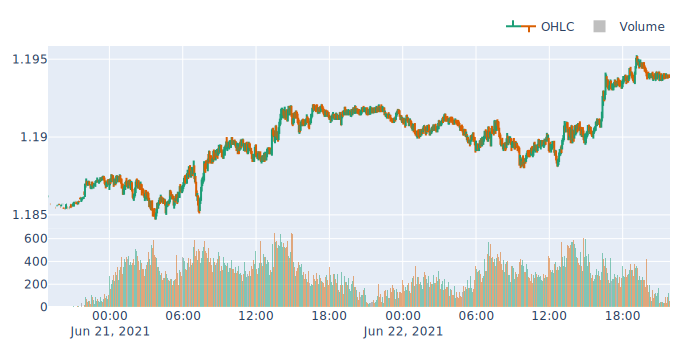

In [7]:
forex_data[:1000].vbt.ohlcv.plot().show_svg()

In [12]:
smc = smc(forex_data, 10, 0, "30T")

TypeError: 'Series' object is not callable